# Statistical Modeling using Sleep Health and Lifestyle Dataset
### STAT301 Group 13 Final Report
April 12th, 2025

**Contributors:** \
Yuki Matsushima #84356377 \
Masaya Tanaka #59477232 \
Aryan Arora #81663510 

In [111]:
library(tidyverse)
library(caret)
library(pROC)
library(boot)
library(glmnet)

## Introduction 

We use the Sleep Health and Lifestyle Dataset comprising 374 observations and 13 variables representing sleep duration, physical activity, blood pressure, stress, and BMI.

Sleep disorders are increasingly being recognized as an important public health issue that has an impact on general well-being, cognitive functioning, and future health. Recognition of risk factors early on is likely to ensure better health results and early intervention.

In this study, we examine several health and lifestyle factors that can be used to predict the presence of a sleep disorder.

Furthermore, through the development of a predictive model, we aim to identify which of these factors are most relevant in predicting the presence of a sleep disorder.

### Our research question is: 
Can various health factors be used to determine whether or not someone has a sleep disorder.

## Methods 
### 1. Cleaning an Preprocessing of Data
We begin by cleaning and preprocessing the dataset. We rename variables to snake_case, Split the blood pressure column into two seperate columns: systolic and diastoclic bp, Mutate the bmi category to Overweight,Obese,Normal,Underweight and we create a binary version of sleep disorder where 0 is no disorder and 1 represents a sleeping disorder

### 2. Model Formation
Using LASSO Logistic Regression, we identify key predictors of sleep disorder. We split the training and test data by 60% (60% is training data, 40% is test data) and perform a 10 fold cross validation to determine optimal labda value.

### 3. Evaluating the test set
We then evaluate the model using the test set which consists of 40% of the data. Here we generate predicted probailities using the fitted LASSO Model and evaluate performance using an ROC curve( Receiver Operating Characterisitic) and calculated the Area under the curve to assess accuracy.



### a) Data

In [112]:
# cell copied from Yuki's assignment 2
# read the dataset
sleep_data <- read_csv("https://raw.githubusercontent.com/yma24ma/stat301_project/refs/heads/main/Sleep_health_and_lifestyle_dataset.csv")
head(sleep_data)

Rows: 374 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Gender, Occupation, BMI Category, Blood Pressure, Sleep Disorder
dbl (8): Person ID, Age, Sleep Duration, Quality of Sleep, Physical Activity...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia


#### Description
(Cell copied from Yuki's assignment 2) \
The Sleep Health and Lifestyle Dataset consists of 374 observations and 13 variables related to individuals' sleep habits, physical health, and lifestyle choices. It aims to analyze the factors influencing sleep quality and overall well-being. This dataset is clarified as synthetic and created by Laksika Tharmalingam for illustrative purposes, (thus its not observational nor experimental) and can be retrieved through Kaggle. (https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset?resource=download)

#### Variables 
(Cell copied from Yuki's assignment 2) 
|Variable Name|Type|Description|
|-------------|----|-----------|
|`Person ID`|Integer|An identifier for each individual.|
|`Gender`|Categorical|The gender of the person (Male/Female).|
|`Age`|Integer|The age of the person in years.|
|`Occupation`|String|The occupation or profession of the person.|
|`Sleep Duration`|Float|The number of hours the person sleeps per day.|
|`Quality of Sleep`|Integer|A subjective rating of the quality of sleep, ranging from 1 to 10.|
|`Physical Activity Level`|Integer|The number of minutes the person engages in physical activity daily.|
|`Stress Level`|Integer|A subjective rating of the stress level experienced by the person, ranging from 1 to 10.|
|`BMI Category`|Categorical|The BMI category of the person (Underweight, Normal, Overweight).|
|`Blood Pressure`|String|The blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure. (stored as a character)|
|`Heart Rate`|Integer|The resting heart rate of the person in beats per minute.|
|`Daily Steps`|Integer|The number of steps the person takes per day.|
|`Sleep Disorder`|Categorical|The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea).|

**Pre-Selection Variables:** \
(cell copied from Yuki's assignment 2)\
`Person ID` can be dropped since they do not provide sufficient information about sleep and lifestyle information. This will be done later after splitting the data

### b) Explanatory Data Analysis

In [113]:
# cell copied from Yuki's assignment 2
# convert the variable names into snake_case format
colnames(sleep_data) <- gsub(" ", "_", tolower(colnames(sleep_data)))

# split the blood_pressure variable into systolic_bp and diastolic_bp and mutate into a numerical format
sleep_data <- sleep_data |>
separate(blood_pressure, into = c("systolic_bp", "diastolic_bp")) |>
mutate(systolic_bp = as.numeric(systolic_bp),
       diastolic_bp = as.numeric(diastolic_bp))

# mutate bmi_category into "Underweight", "Normal", "Overweight", and "Obese"
# I chose to keep "Obese" since it's recognized by the governemnt of Canada as one of the classification of BMI
sleep_data <- sleep_data |>
mutate(bmi_category = if_else(bmi_category %in% c("Normal", "Normal Weight"), "Normal", bmi_category))

head(sleep_data)

person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,systolic_bp,diastolic_bp,heart_rate,daily_steps,sleep_disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126,83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,Sleep Apnea
6,Male,28,Software Engineer,5.9,4,30,8,Obese,140,90,85,3000,Insomnia


#### Visualization

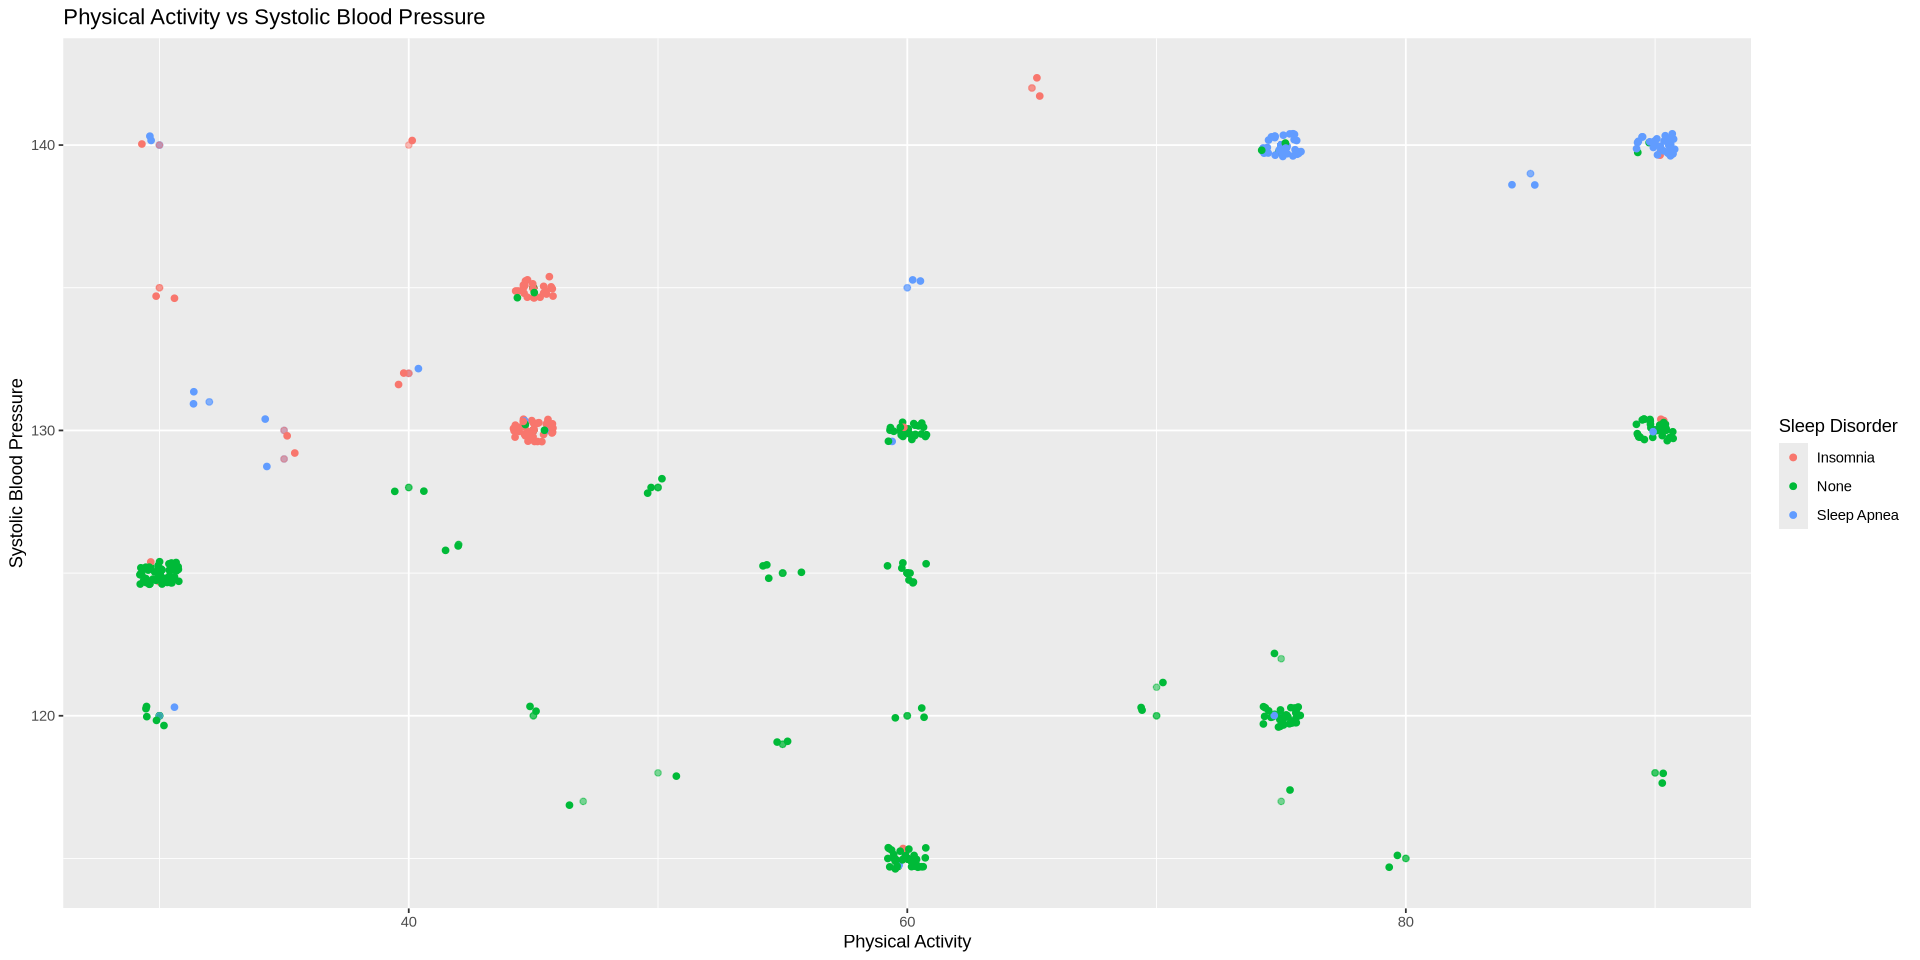

In [114]:
# cell copied from Yuki's assignment 2
# scatter plot using physical activity level vs systolic blood pressure
pa_sbp_plot <- sleep_data |>
ggplot(aes(x = physical_activity_level, y = systolic_bp, color = sleep_disorder)) +
geom_point(alpha = 0.5) +
geom_jitter() +
labs(title = "Physical Activity vs Systolic Blood Pressure", x = "Physical Activity", y = "Systolic Blood Pressure", color = "Sleep Disorder")

pa_sbp_plot

Plot. 1

**Plot.1 Interpretation:** \
(cell copied from Yuki's assignment 2) \
This plot is relevant to addressing my research question because it visually explores the relationship between physical activity level, systolic blood pressure, and sleep disorders. Since my study aims to predict the likelihood of having a sleep disorder based on various health factors, this visualization helps in understanding wether physical activity and blood pressure level differ among individuals with and without sleep disorders. I chose those variables because they are key health factors that could be associated with sleep disorders and they do not involve subjective rating (such as quality_of_sleep and stress_level) and also are not rounded up or down heavily (such as daily_steps).

From Plot. 1, we can observe potential clustering patterns based on sleep disorder categories. It looks like the people with higher systolic blood pressure tends to have more sleep disorders since most of the blue and red plots are scattered on the top half of the scatter plot. 

In [115]:
# another visualization

Plot. 2

**Plot.2 Interpretation:** \
interpretation for plot. 2

#### Summary Table:

In [116]:
# code for summary table

**Summary Table Interpretation:** \
interpretation for summary table

### c) Methods: Plan (Using Lasso for Model shrinkage and variable selection) 
Contributer: Masaya Tanaka

#### Logistic Regression model
We will be using Logistic Regression to create a prediction model for a binary variable(whether a person has a sleeping disorder or not). Since the target variable is binary, we will be using logistic regression.

#### Lasso

For model selection we will be using LASSO to simplify the model by selecting the variables by making some of the coefficients to 0. This has two effects: simplifying the model and generalizing the model by penalizing. Since Ridge can not eliminate any variable, it will be more affective to use LASSO. 

## Computational Code and Output

In [117]:
# making sleep_disorder binary and dropping person_id
# Yuki Matsushima
sleep_data_binomial <- sleep_data |>
mutate(sleep_disorder = if_else(sleep_disorder == "None", 0, 1)) 

head(sleep_data_binomial)

person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,systolic_bp,diastolic_bp,heart_rate,daily_steps,sleep_disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126,83,77,4200,0
2,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,0
3,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,0
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,1
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,1
6,Male,28,Software Engineer,5.9,4,30,8,Obese,140,90,85,3000,1


In [118]:
# Splitting the data set into two parts: Test and Train. 
# Masaya Tanaka

set.seed(20250411)


sleep_disorder_train <- 
    sleep_data_binomial |>
    slice_sample(prop = 0.6) 

sleep_disorder_test <- 
    sleep_data_binomial |>
    anti_join(sleep_disorder_train, by = "person_id")

sleep_disorder_train <- 
    sleep_disorder_train |>
    select(-person_id)

sleep_disorder_test <- 
    sleep_disorder_test |>
    select(-person_id)


In [119]:
# Creating model matrices to prepare for glmnet
# Masaya Tanaka

model_matrix_X_train <- 
    model.matrix(sleep_disorder ~ . , data = sleep_disorder_train)[,-1]

matrix_Y_train <- 
    as.matrix(sleep_disorder_train$sleep_disorder, ncol = 1)

#### LASSO Logistic Regression 
Since we have already prepared the two matrices, we will find a value of lamda for largest AUC when lasso is applied. 

We will be using cross-validation choosing to fold 10 times.

In [120]:
# using glmnet to find the appropriate value of lambda. 
# Masaya Tanaka
set.seed(1234)
sleep_disorder_cv_lambda_lasso <- 
    cv.glmnet(
        x = model_matrix_X_train,
        y = matrix_Y_train,
        alpha = 1, 
        family = "binomial",
        type.measure = "auc", 
        nfolds = 10)

sleep_disorder_cv_lambda_lasso


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure      SE Nonzero
min 0.05087    22  0.9356 0.02411       8
1se 0.29793     3  0.9308 0.02445       2

#### Choosing Lambda Value

Given the result of cross validation, we have two lamda options to choose from. One is the ƛ = 0.02332 which will maximize the value of the AUC but will have more predictor values and less genralized. The Second option is to let ƛ = 0.26191 which will have only three selected predictor values and more generalized model. 

We will visualize this the AUC values on y axis and different lambda values on x axis

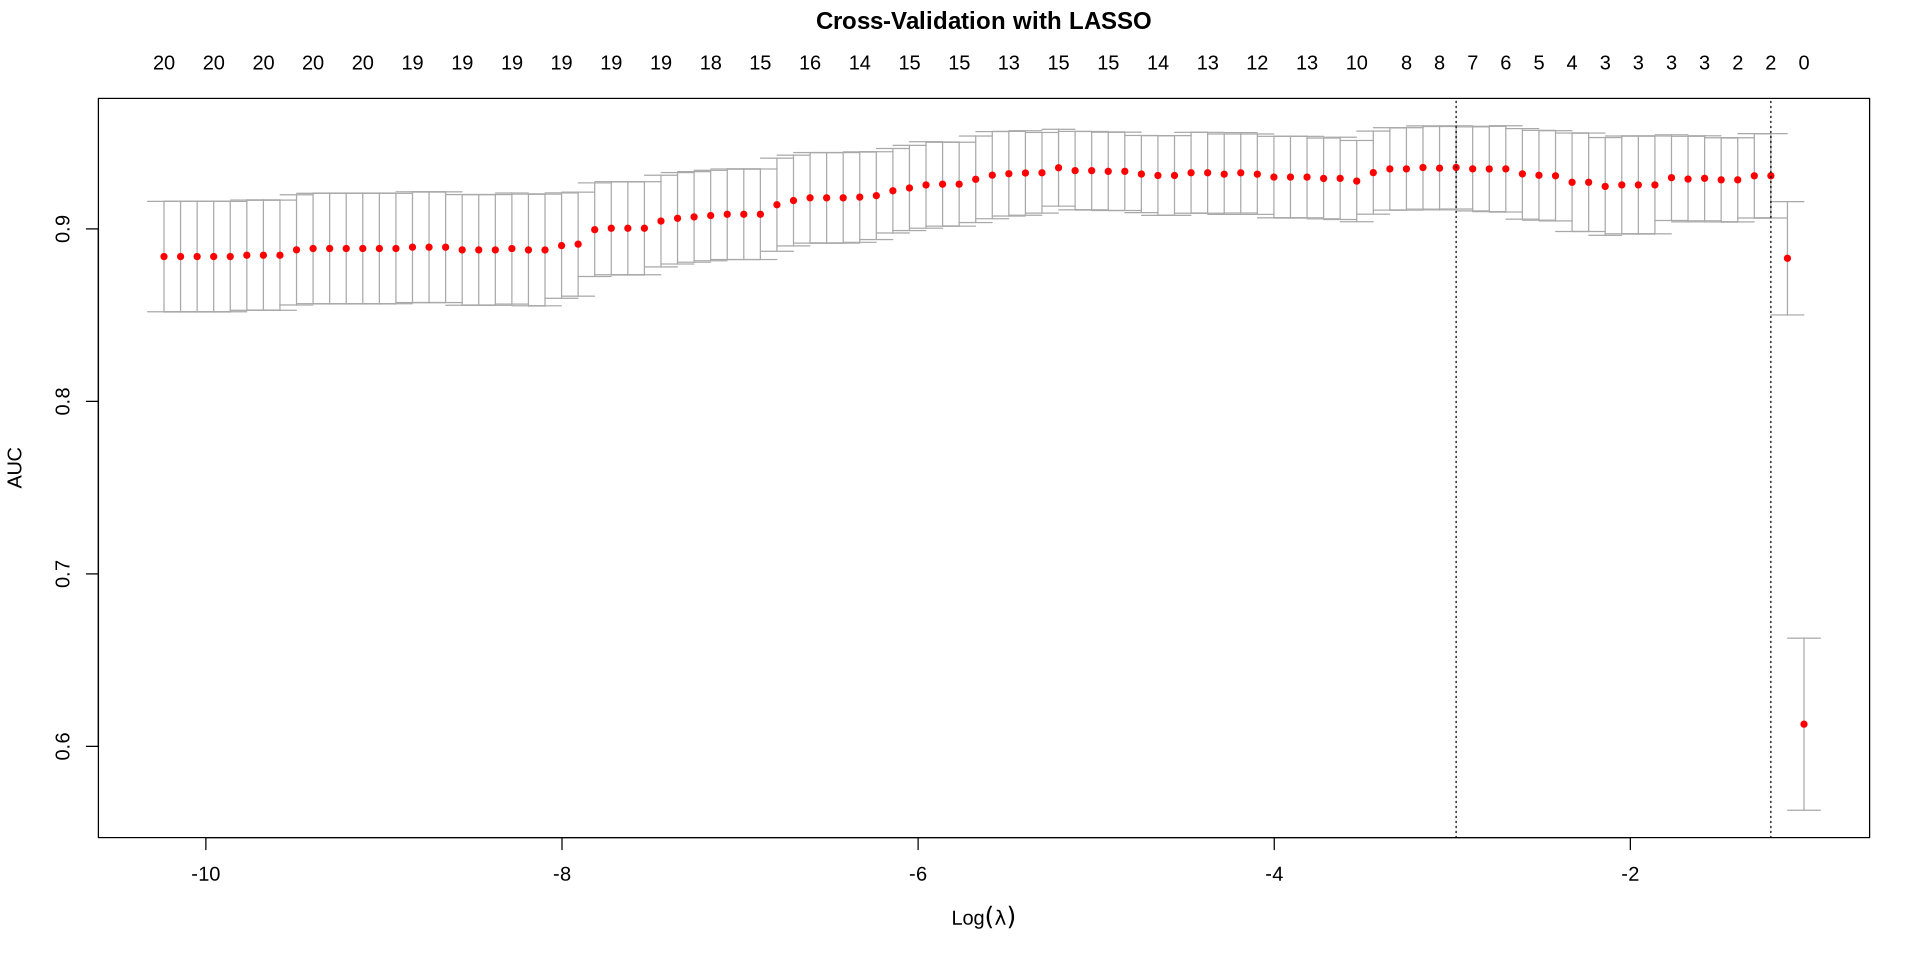

In [121]:
options(repr.plot.width = 16, repr.plot.height = 8)
plot(sleep_disorder_cv_lambda_lasso , main = "Cross-Validation with LASSO\n\n")

In this case, we will choose to use the largest lamda with in 1 standard error since we want to create a generalized and simple model this time.

In [122]:
# Choosing the 1se lambda value
lambda_1se_AUC_LASSO <- round(sleep_disorder_cv_lambda_lasso$lambda.1se, 4)
lambda_1se_AUC_LASSO

[1] 0.2979

#### Creating the fitted LASSO model and 1se lambda value

Now, given the lambda value, we will be fitting the lasso model and the coefficient values that are chosen given using the lasso shrinkage method. 

In [123]:
# fitting the model using the 1se lambda
# Masaya Tanaka 
set.seed(1234)

sleep_disorder_LASSO_1se_AUC <- glmnet(
    x = model_matrix_X_train, y = matrix_Y_train,
    alpha = 1,
    family = "binomial", 
    lambda = lambda_1se_AUC_LASSO)

coef(sleep_disorder_LASSO_1se_AUC)

23 x 1 sparse Matrix of class "dgCMatrix"
                                         s0
(Intercept)                    -0.898939489
genderMale                      .          
age                             .          
occupationDoctor                .          
occupationEngineer              .          
occupationLawyer                .          
occupationManager               .          
occupationNurse                 .          
occupationSales Representative  .          
occupationSalesperson           .          
occupationScientist             .          
occupationSoftware Engineer     .          
occupationTeacher               .          
sleep_duration                  .          
quality_of_sleep                .          
physical_activity_level         .          
stress_level                    .          
bmi_categoryObese               .          
bmi_categoryOverweight          0.441154613
systolic_bp                     .          
diastolic_bp                    0.

### Selected Variables (NOT DONE FILL PART THIS IN)

some comment on the variable selected 

mention about this why bmi category overweight was selected and obese was not. 

#### Testing the lasso model created using the test sets

Now we will use the test set to evaluate the quality of the model created. 

In [124]:
# creating model matrix for test data set and using roc function for test
# Masaya Tanaka
model_matrix_X_test <- 
    model.matrix(sleep_disorder ~ . , data = sleep_disorder_test)

predictor = predict(
    sleep_disorder_LASSO_1se_AUC,
    newx = model_matrix_X_test,
    s = "lambda.1se",
    type = "response")

ROC_lasso <- roc(
    response = sleep_disorder_test$sleep_disorder, 
    predictor = predictor)

ROC_lasso

Setting levels: control = 0, case = 1

Warning message in roc.default(response = sleep_disorder_test$sleep_disorder, predictor = predictor):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases




Call:
roc.default(response = sleep_disorder_test$sleep_disorder, predictor = predictor)

Data: predictor in 97 controls (sleep_disorder_test$sleep_disorder 0) < 53 cases (sleep_disorder_test$sleep_disorder 1).
Area under the curve: 0.9553

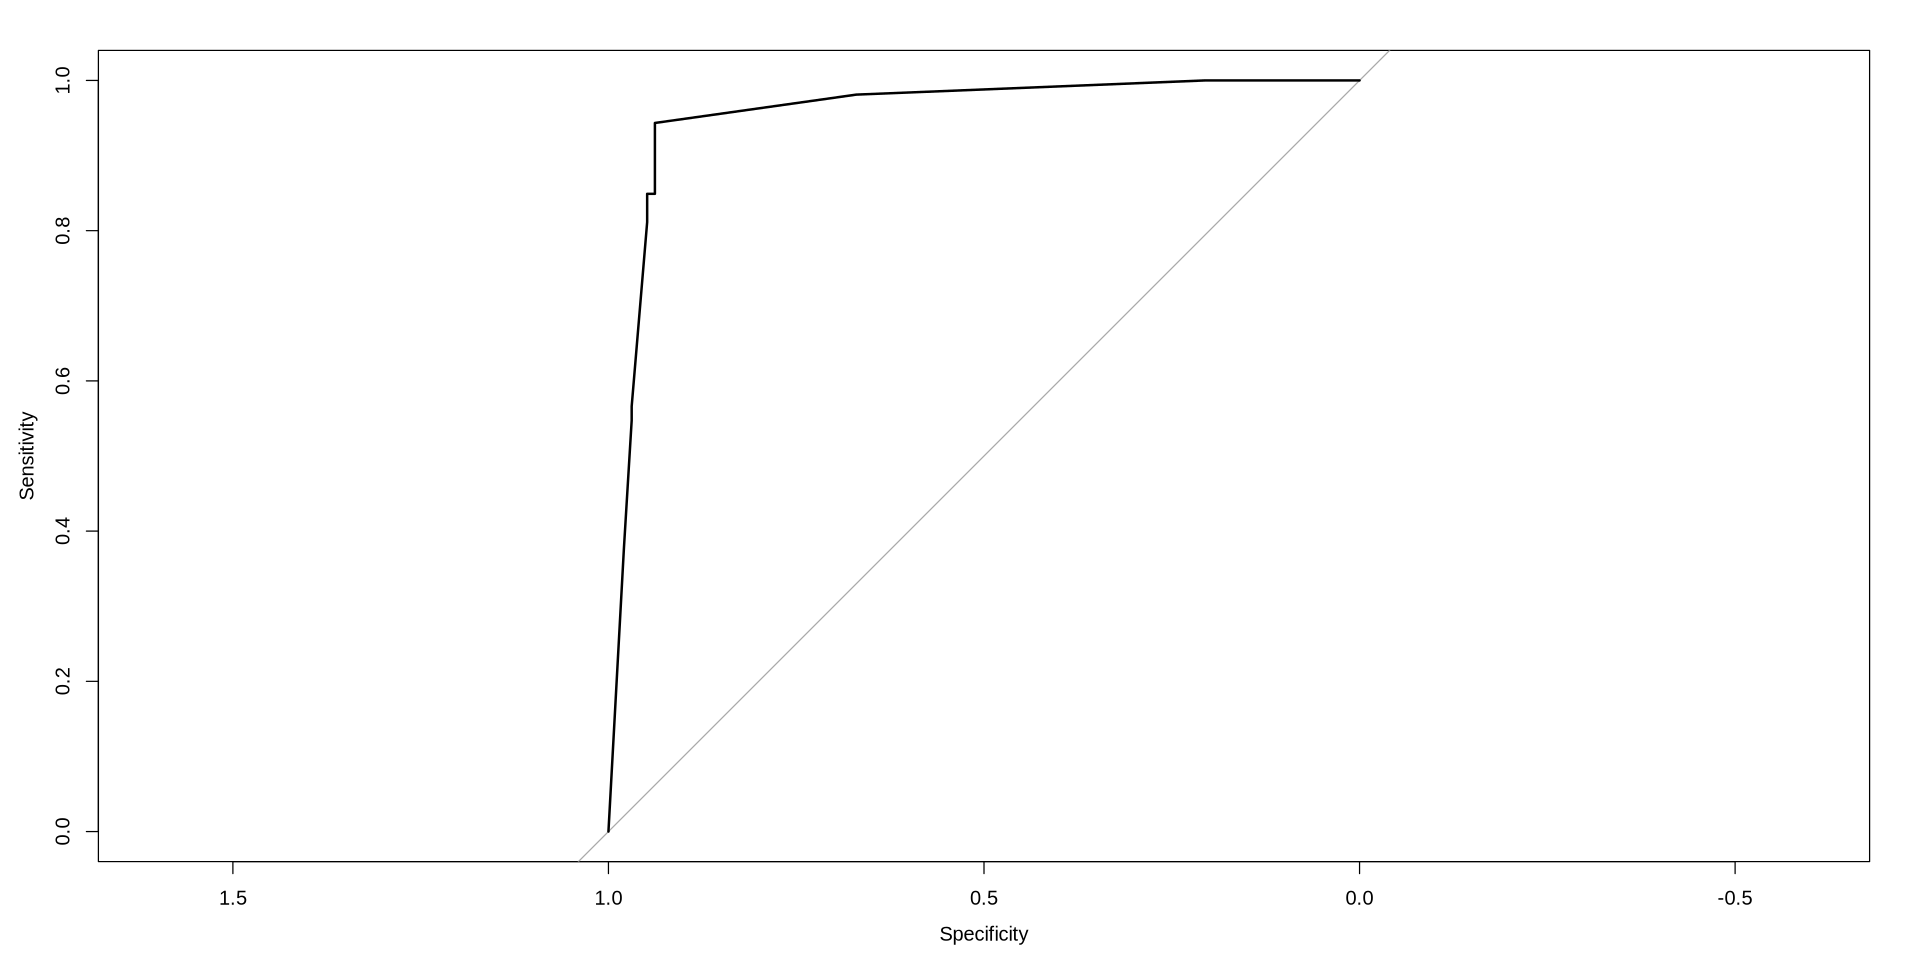

In [125]:
# plot the ROC curve for the lasso model
# Masaya Tanaka

plot(ROC_lasso)

## Discussion

## References